In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

from scipy.stats import t, kstest
from scipy.optimize import minimize
import scipy.stats as stats

from datetime import datetime
from tqdm import tqdm

In [38]:
base_colors = ["#14284F", "#EB008B", "#5CD6AE", "#FFB81C", "#C2AFF0",'darkred','orange']
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=base_colors 
)

In [39]:
# Define the rolling window size (e.g., 252 trading days for 1 year)
rolling_window = 251 # window to fit GARCH

# Calculate rolling historical VaR at the 99% confidence level
confidence_level = 0.95

# Number of days to simulate ahead & assess
num_days = 10

# Monte Carlo simulation parameters
num_simulations = 5000  # Number of simulations

# fix imulation with random state
random_number = 42

# Download Prices

In [40]:
# Download S&P 500 data from Yahoo Finance
#'^GSPC'
#'^FTSE' FTSE100
#'^IXIC' Nasdaq composite
#'^FCHI' CAC40
#'^N100' Euronext 100
price = yf.download(['^GSPC', '^FTSE'], start='2000-01-01', end='2024-05-04')
price.index = pd.to_datetime(price.index)

# Calculate daily log returns
log_returns = np.log(price ['Adj Close'] / price ['Adj Close'].shift(1))
returns = price ['Adj Close'] / price ['Adj Close'].shift(1)-1
# Drop the first row with NaN value
log_returns = log_returns.dropna()
returns = returns.dropna()
log_returns.head(5)

[*********************100%%**********************]  2 of 2 completed


Ticker,^FTSE,^GSPC
Date,,
2000-01-05,-0.019695,0.001920
2000-01-06,-0.013664,0.000955
2000-01-07,0.008894,0.026730
2000-01-10,0.015695,0.011128
2000-01-11,-0.013530,-0.013149


In [41]:
log_returns = pd.DataFrame(log_returns)
returns = pd.DataFrame(returns)

# Check distributions

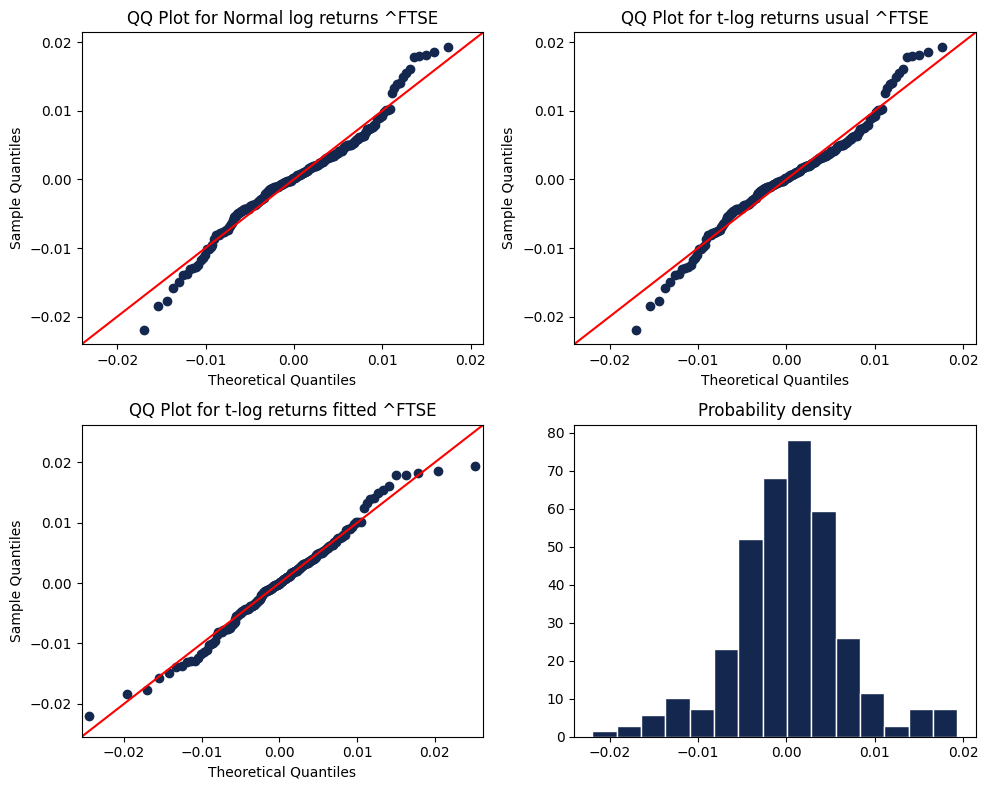

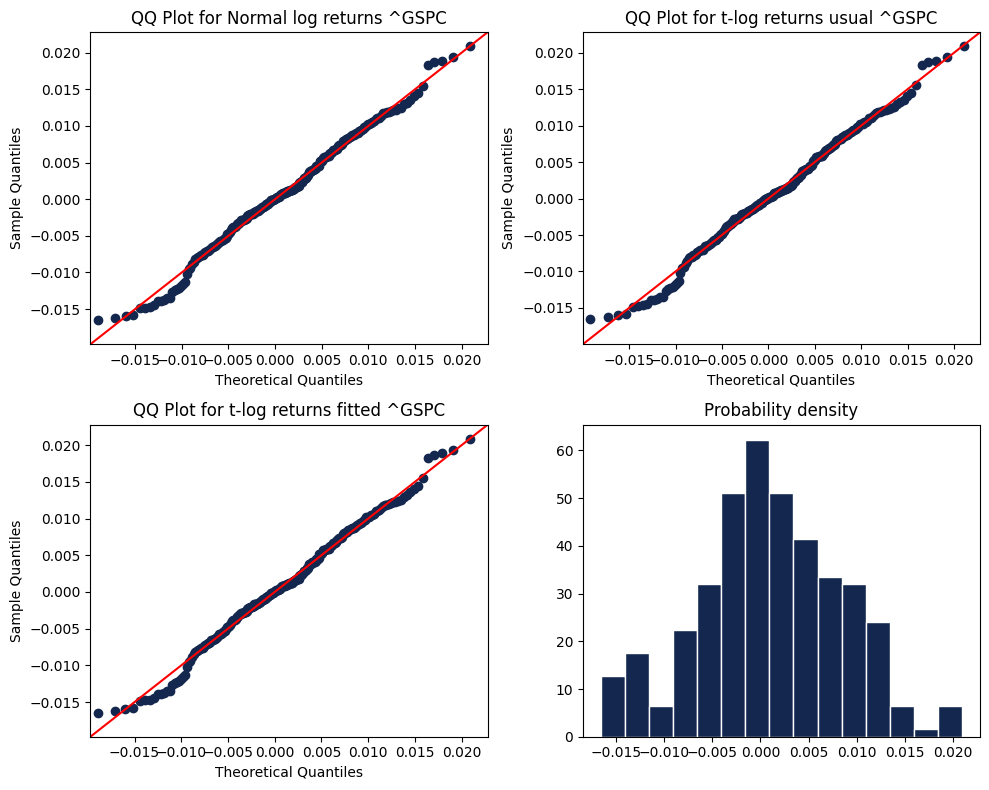

In [42]:
import statsmodels.api as sm

# Function to plot QQ plot
def plot_qq(data, dist, distargs, loc=3, scale=10, name = '', ax = None):
    sm.qqplot(data, dist=dist, distargs=distargs, loc = loc, scale = scale,line='45', ax=ax)
    ax.set_title(f"QQ Plot for {name}")
        
for col in returns.columns:
    arr2 = log_returns[col][-rolling_window:]
    
    fig, ax = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
    
    # Calling and plotting for Normal distribution
    # Make parameters as in Geometric Brownian Motion
    mu = arr2.mean()
    sigma = arr2.std()
    plot_qq(arr2, stats.norm, distargs=(), loc = mu - 0.5*sigma**2, scale = sigma,name ='Normal log returns ' + col, ax = ax[0, 0])
    
    # Calling and plotting for t-distribution
    # did not understand how to implement in VaR simulation, but let it be here
    params  =  stats.t.fit(arr2)
    plot_qq(arr2, stats.t, distargs=(params[0],), loc = params[1], scale = params[2], name ='t-log returns fitted ' +col, ax = ax[1, 0])

    # Do Geometric Brownian Motion, but use t distribution with df = N-1 instead of normal distribution
    plot_qq(arr2, stats.t, distargs=(len(arr2)-1,), loc = mu - 0.5*sigma**2, scale = sigma, name ='t-log returns usual ' +col,
            ax = ax[0, 1])

    ax[1,1].hist(arr2, bins = 15, edgecolor = 'white', density=True)
    ax[1,1].set_title('Probability density')
    
    plt.tight_layout()
    plt.show()

# Run Simulations

In [43]:
def monte_carlo_var_garch(log_returns, num_simulations, num_days, confidence_level):
    # Fit a GARCH(1,1) model to the log returns
    log_returns = log_returns
    garch_model = arch_model(log_returns*100, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    
    # Get the mean return and GARCH-based forecasted volatility
    mean_return = log_returns.mean()
    forecast = garch_fit.forecast(horizon=num_days)
    std_return = np.sqrt(forecast.variance.values[-1, :])/100
    
    # Simulate future returns for the given number of days
    # T = 1; T is one day
    simulated_log_returns = np.random.normal(mean_return - 0.5*(std_return**2), std_return, (num_simulations, num_days))

    # Calculate cumulative returns for each simulation over the specified number of days
    cumulative_log_returns = simulated_log_returns.sum(axis=1)

    # Calculate the simulated VaR at the desired confidence level
    simulated_var = np.percentile(cumulative_log_returns, (1 - confidence_level) * 100)

    return simulated_var

In [44]:
num_simulations = 10000
log_vars = pd.DataFrame(index = log_returns.index)
for col in tqdm(log_returns.columns):
    log_vars.loc[:,col] = log_returns[col].rolling(rolling_window).apply(lambda x: monte_carlo_var_garch(x, num_simulations, num_days, confidence_level))

100%|████████████████████████████████████████████| 2/2 [03:40<00:00, 110.11s/it]


In [45]:
def parametric_var_garch_norm(log_returns, num_days, confidence_level):
    # Fit a GARCH(1,1) model to the log returns
    log_returns = log_returns
    garch_model = arch_model(log_returns * 100, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    # Get the mean return and GARCH-based forecasted volatility
    mean_return = log_returns.mean()
    forecast = garch_fit.forecast(horizon=num_days)
    forecasted_variance = forecast.variance.values[-1, :].sum()  # Sum variance over the forecast horizon
    forecasted_volatility = np.sqrt(forecasted_variance)/ 100

    # Calculate the parametric VaR at the desired confidence level
    z_score = stats.norm.ppf((1 - confidence_level))
    parametric_var = mean_return * num_days + z_score * forecasted_volatility

    # use geometric brownian motion better
    return parametric_var

In [46]:
log_vars_parametric_norm = pd.DataFrame(index = log_returns.index)
for col in tqdm(log_returns.columns):
    log_vars_parametric_norm.loc[:,col] = log_returns[col\
    ].rolling(rolling_window).apply(lambda x: parametric_var_garch_norm(x, num_days, confidence_level))

100%|█████████████████████████████████████████████| 2/2 [03:00<00:00, 90.18s/it]


In [51]:
'''
def parametric_var_garch_t(log_returns, num_days, confidence_level):
    # Fit a GARCH(1,1) model to the log returns
    log_returns = log_returns 
    garch_model = arch_model(log_returns * 100, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    # Get the mean return and GARCH-based forecasted volatility
    mean_return = log_returns.mean()
    forecast = garch_fit.forecast(horizon=num_days)
    forecasted_variance = forecast.variance.values[-1, :].sum()   # Sum variance over the forecast horizon
    forecasted_volatility = np.sqrt(forecasted_variance)/ 100

    # Calculate the parametric VaR at the desired confidence level
    df, loc, scale = t.fit(log_returns, loc = 0, scale = 1)
    t_score = stats.t.ppf((1 - confidence_level), df= num_days - 1, loc = loc, scale = scale)
    parametric_var = mean_return * num_days + t_score * forecasted_volatility
    
    return parametric_var
# there is some error in specified distribution; tried many ideas, they fail.
''';

In [48]:
def parametric_var_garch_t_standard(log_returns, num_days, confidence_level):
    # Fit a GARCH(1,1) model to the log returns
    log_returns = log_returns
    garch_model = arch_model(log_returns * 100, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    # Get the mean return and GARCH-based forecasted volatility
    mean_return = log_returns.mean()
    forecast = garch_fit.forecast(horizon=num_days)
    forecasted_variance = forecast.variance.values[-1, :].sum()  # Sum variance over the forecast horizon
    forecasted_volatility = np.sqrt(forecasted_variance) / 100

    # Calculate the parametric VaR at the desired confidence level
    #df, loc, scale = t.fit(log_returns, loc = 0, scale = 1)
    t_score = stats.t.ppf((1 - confidence_level), df = num_days - 1, loc = 0, scale = 1)
    parametric_var = mean_return * num_days + t_score * forecasted_volatility
    
    return parametric_var
    
log_vars_parametric_t_standard = pd.DataFrame(index = log_returns.index)
for col in tqdm(log_returns.columns):
    log_vars_parametric_t_standard.loc[:,col] = log_returns[col\
    ].rolling(rolling_window).apply(lambda x: parametric_var_garch_t_standard(x, num_days, confidence_level))

100%|████████████████████████████████████████████| 2/2 [03:24<00:00, 102.36s/it]


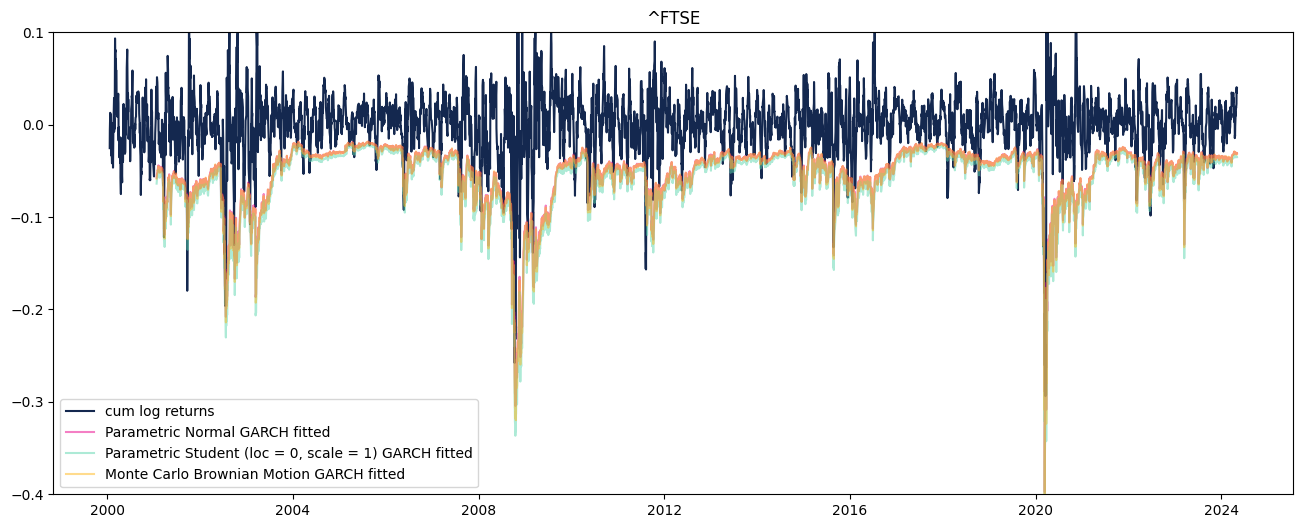

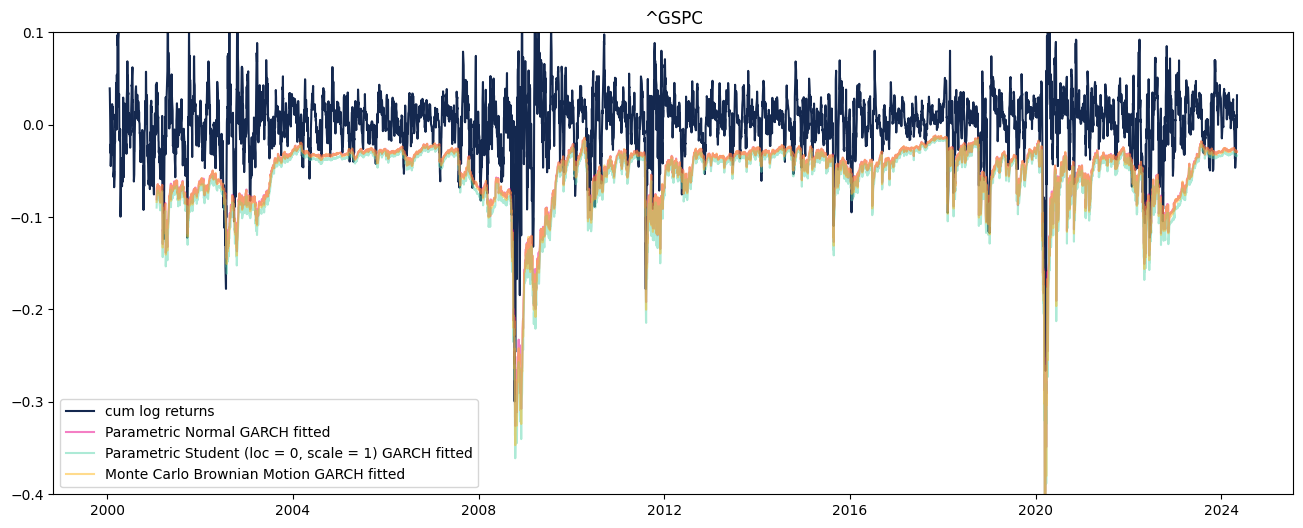

In [49]:
# plot VaRs
for col in log_returns.columns:
    plt.figure(figsize =(16,6))
    plt.title(col)
    plt.plot(log_returns[col].rolling(num_days).sum(), label = 'cum log returns')
    plt.plot(log_vars_parametric_norm[col], alpha = 0.5, label = 'Parametric Normal GARCH fitted')
    plt.plot(log_vars_parametric_t_standard[col], alpha = 0.5, label = 'Parametric Student (loc = 0, scale = 1) GARCH fitted')
    plt.plot(log_vars[col], alpha = 0.5, label = 'Monte Carlo Brownian Motion GARCH fitted')
    plt.ylim(-0.4,0.1)
    plt.legend();

# Validate VaRs

In [52]:
startng_date = '2020-01-01'
for col in log_returns.columns:
    print(col)

    print(f'{np.mean(log_returns[col].rolling(num_days).sum()[log_vars[col].dropna().index][startng_date:] < log_vars[col].dropna()[startng_date:]).round(4)*100:.2}% real break of var under monte carlo brownian motion')

    print(f'{np.mean(log_returns[col].rolling(num_days).sum()[log_vars_parametric_t_standard[col].dropna().index][startng_date:] < log_vars_parametric_t_standard[col].dropna()[startng_date:]).round(4)*100:.2}% real break of var under Parametric Student (loc = 0, scale = 1) GARCH fitted')
        
    print(f'{np.mean(log_returns[col].rolling(num_days).sum()[log_vars_parametric_norm[col].dropna().index][startng_date:] < log_vars_parametric_norm[col].dropna()[startng_date:])*100:.2}% real break of var under Normal GARCH fitted')
    
    print()

^FTSE
2.5% real break of var under monte carlo brownian motion
1.2% real break of var under Parametric Student (loc = 0, scale = 1) GARCH fitted
2.5% real break of var under Normal GARCH fitted

^GSPC
3.5% real break of var under monte carlo brownian motion
2.2% real break of var under Parametric Student (loc = 0, scale = 1) GARCH fitted
3.7% real break of var under Normal GARCH fitted



In [53]:
from scipy.stats import chi2

def kupiec_pof_test(return_values,var_values, confidence_level):
    # Calculate the number of exceptions
    exceptions = return_values < var_values
    num_exceptions = np.sum(exceptions)
    
    # Calculate the proportion of exceptions
    T = len(return_values)  # Total number of observations
    pi = num_exceptions / T  # Observed failure rate
    alpha = 1 - confidence_level  # Expected failure rate

    # Kupiec POF test statistic
    lr_pof = -2 * np.log(((1 - pi)**(T - num_exceptions) * pi**num_exceptions) / 
                         ((1 - alpha)**(T - num_exceptions) * alpha**num_exceptions))
    
    # p-value from the chi-squared distribution with 1 degree of freedom
    p_value = chi2.sf(lr_pof, df=1)
    
    return lr_pof, p_value

In [57]:
print(f'Null Hypothesis (H0): The actual proportion of days where the loss exceeds the VaR (exceptions) is {np.round((1-confidence_level),3)}')
print()
for col in log_returns.columns:
    print(col)
    
    _, pvalue = kupiec_pof_test(log_returns[col].rolling(num_days).sum()[log_vars[col].dropna().index][startng_date:],
                                        log_vars[col].dropna()[startng_date:],
                                        confidence_level)
    print(f'{np.round(pvalue,6)} p-value of test for real break of var under Parametric Student Monte Carlo GARCH fitted')

    
    _, pvalue = kupiec_pof_test(log_returns[col].rolling(num_days).sum()[log_vars_parametric_t_standard[col].dropna().index][startng_date:],
                                        log_vars_parametric_t_standard[col].dropna()[startng_date:],
                                        confidence_level)
    print(f'{np.round(pvalue,6)} p-value of test for real break of var under Parametric Student (loc = 0, scale = 1) GARCH fitted')


    _, pvalue = kupiec_pof_test(log_returns[col].rolling(num_days).sum()[log_vars_parametric_norm[col].dropna().index][startng_date:],
                                        log_vars_parametric_norm[col].dropna()[startng_date:],
                                        confidence_level)
    print(f'{np.round(pvalue,6)} p-value of test for real break of var under Normal GARCH fitted')
    print()

Null Hypothesis (H0): The actual proportion of days where the loss exceeds the VaR (exceptions) is 0.05

^FTSE
1.0 p-value of test for real break of var under Parametric Student Monte Carlo GARCH fitted
1.0 p-value of test for real break of var under Parametric Student (loc = 0, scale = 1) GARCH fitted
1.0 p-value of test for real break of var under Normal GARCH fitted

^GSPC
1.0 p-value of test for real break of var under Parametric Student Monte Carlo GARCH fitted
1.0 p-value of test for real break of var under Parametric Student (loc = 0, scale = 1) GARCH fitted
1.0 p-value of test for real break of var under Normal GARCH fitted



All models are good, because H0 is not rejected => will take the one that was consistend by distributions

# Small experiment: Use VIX instead of GARCHed volatility

In [67]:
vix = yf.download(['^VIX'], start='2002-01-01', end='2024-05-03')['Adj Close']
vix.index = pd.to_datetime(vix.index)

[*********************100%%**********************]  1 of 1 completed


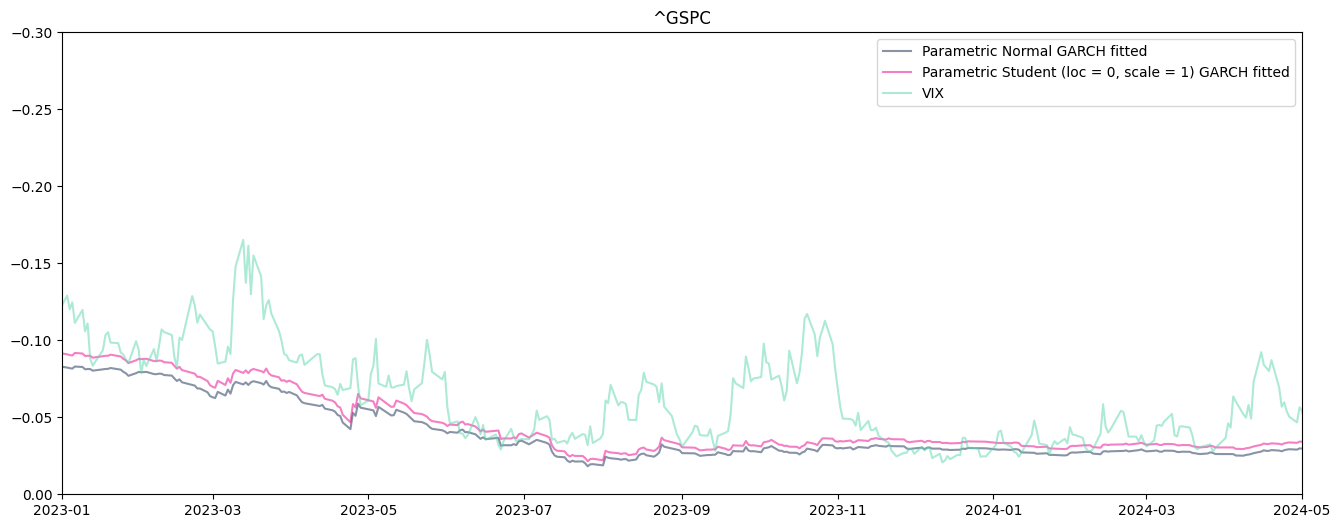

In [68]:
for col in ['^GSPC']:
    plt.figure(figsize =(16,6))
    plt.title(col)
    plt.plot(log_vars_parametric_norm[col], alpha = 0.5, label = 'Parametric Normal GARCH fitted')
    plt.plot(log_vars_parametric_t_standard[col], alpha = 0.5, label = 'Parametric Student (loc = 0, scale = 1) GARCH fitted')
    plt.plot(vix*-1/100+0.1,alpha = 0.5,label = 'VIX')
    plt.ylim(0,-0.3)
    plt.xlim(datetime(2023,1,1),datetime(2024,5,1))
    plt.legend();

In [69]:
pd.DataFrame([log_vars_parametric_norm[col],
              log_vars_parametric_t_standard[col],
              -1*(log_returns[col]**2).rolling(10).sum(),
              -1*vix[log_vars_parametric_norm[col].index[0]:],
              ]).T.dropna().corr()

,^GSPC,^GSPC,^GSPC,Adj Close
^GSPC,1.000000,0.999934,0.856117,0.903923
^GSPC,0.999934,1.000000,0.858609,0.904172
^GSPC,0.856117,0.858609,1.000000,0.754136
Adj Close,0.903923,0.904172,0.754136,1.000000


In [70]:
np.log(-1*pd.DataFrame([log_vars_parametric_norm[col],
                        log_vars_parametric_t_standard[col],
                        -1*(log_returns[col]**2).rolling(10).sum(),
                        -vix]).T.dropna()).corr()

,^GSPC,^GSPC,^GSPC,Adj Close
^GSPC,1.000000,0.999807,0.860725,0.883123
^GSPC,0.999807,1.000000,0.863687,0.886882
^GSPC,0.860725,0.863687,1.000000,0.843094
Adj Close,0.883123,0.886882,0.843094,1.000000


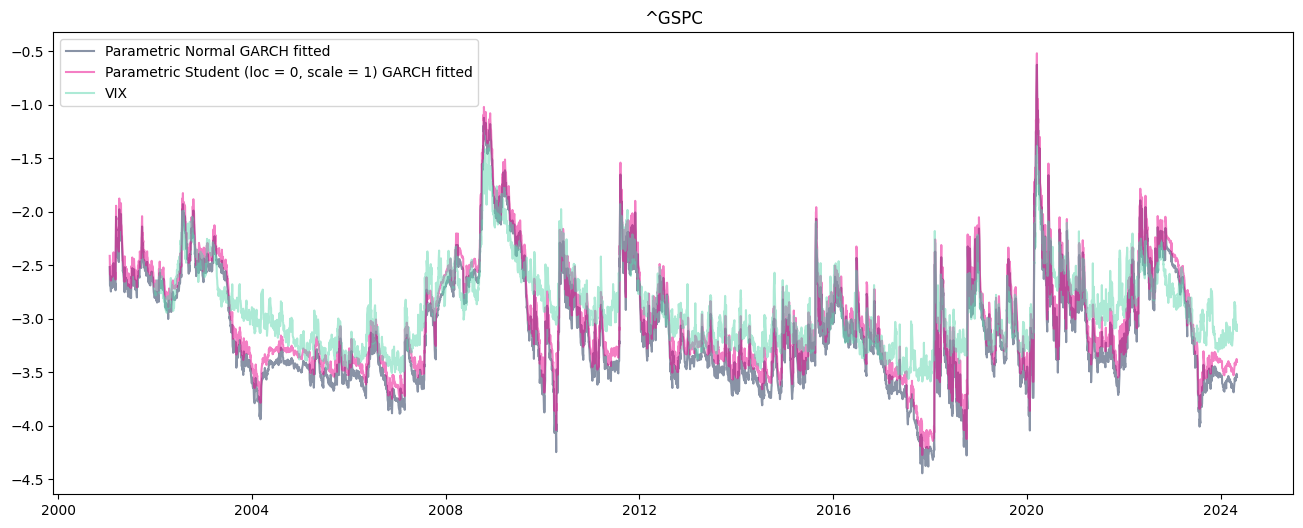

In [71]:
for col in ['^GSPC']:
    plt.figure(figsize =(16,6))
    plt.title(col)
    plt.plot(np.log(-1*log_vars_parametric_norm[col]), alpha = 0.5, label = 'Parametric Normal GARCH fitted')
    plt.plot(np.log(-1*log_vars_parametric_t_standard[col]), alpha = 0.5, label = 'Parametric Student (loc = 0, scale = 1) GARCH fitted')
    plt.plot(np.log(vix/200)-0.5,alpha = 0.5,label = 'VIX')
    #plt.ylim(-0.5,0.15)
    plt.legend();

In [84]:
def garch_variance(log_returns, num_days):
    # Fit a GARCH(1,1) model to the log returns
    log_returns = log_returns
    garch_model = arch_model(log_returns * 100, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    # Get the mean return and GARCH-based forecasted volatility
    forecast = garch_fit.forecast(horizon=num_days)
    forecasted_variance = forecast.variance.values[-1, :].sum()  # Sum variance over the forecast horizon
    #forecasted_volatility = forecasted_variance) / 100
    
    return forecasted_variance

predicted_variance_21 = pd.DataFrame(index = log_returns.index)
for col in tqdm(log_returns.columns):
    predicted_variance_21.loc[:,col] = log_returns[col\
    ].rolling(rolling_window).apply(lambda x: garch_variance(x, num_days = 21))

100%|█████████████████████████████████████████████| 2/2 [03:10<00:00, 95.01s/it]


In [99]:
predicted_variance_10 = pd.DataFrame(index = log_returns.index)
for col in tqdm(log_returns.columns):
    predicted_variance_10.loc[:,col] = log_returns[col\
    ].rolling(rolling_window).apply(lambda x: garch_variance(x, num_days = 10))

100%|█████████████████████████████████████████████| 2/2 [02:59<00:00, 89.98s/it]


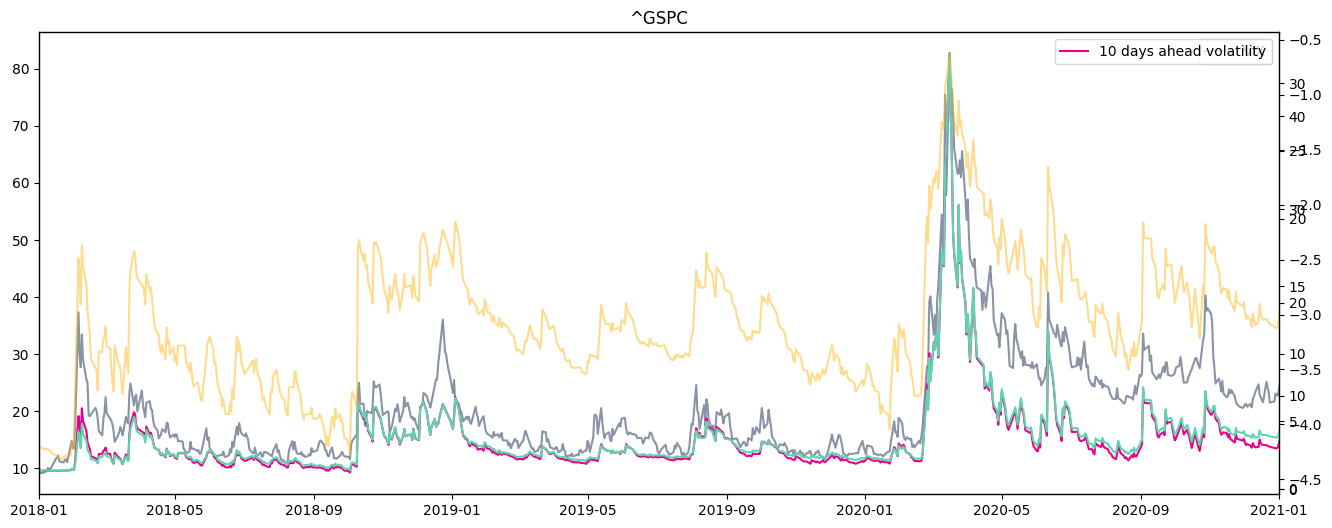

In [111]:
for col in ['^GSPC']:
    fig, ax = plt.subplots(figsize =(16,6))
    plt.title(col)
    ax.plot(vix,alpha = 0.5,label = 'VIX')
    ax1 = ax.twinx()
    # i don't understand why the second sqrt works better; should not have been like that
    ax1.plot(np.sqrt(predicted_variance_10[col]), color = base_colors[1],label = '10 days ahead volatility')

    ax2 = ax.twinx()
    ax2.plot(np.sqrt(predicted_variance_21[col]), color = base_colors[2],label = '21 days ahead volatility')

    ax3 = ax.twinx()
    plt.plot(np.log(-1*log_vars_parametric_norm[col]), alpha = 0.5, label = 'Parametric Normal GARCH fitted', color = base_colors[3])
    #plt.plot(np.log(-1*log_vars_parametric_norm[col]), alpha = 0.5, label = 'Parametric Normal GARCH fitted')
    #plt.plot(np.log(-1*log_vars_parametric_t_standard[col]), alpha = 0.5, label = 'Parametric Student (loc = 0, scale = 1) GARCH fitted')
    plt.xlim(datetime(2018,1,1),datetime(2021,1,1))
    #plt.ylim(-0.5,0.15)
    ax1.legend();
    ax.legend()


In [105]:
pd.DataFrame([vix,
            np.sqrt(predicted_variance_21['^GSPC']),
            np.sqrt(predicted_variance_10['^GSPC'])], index = ['vix','garch volatility 21', 'garch volatility 10']).T.dropna().corr()

,vix,garch volatility 21,garch volatility 10
vix,1.000000,0.897269,0.900343
garch volatility 21,0.897269,1.000000,0.997289
garch volatility 10,0.900343,0.997289,1.000000


fine

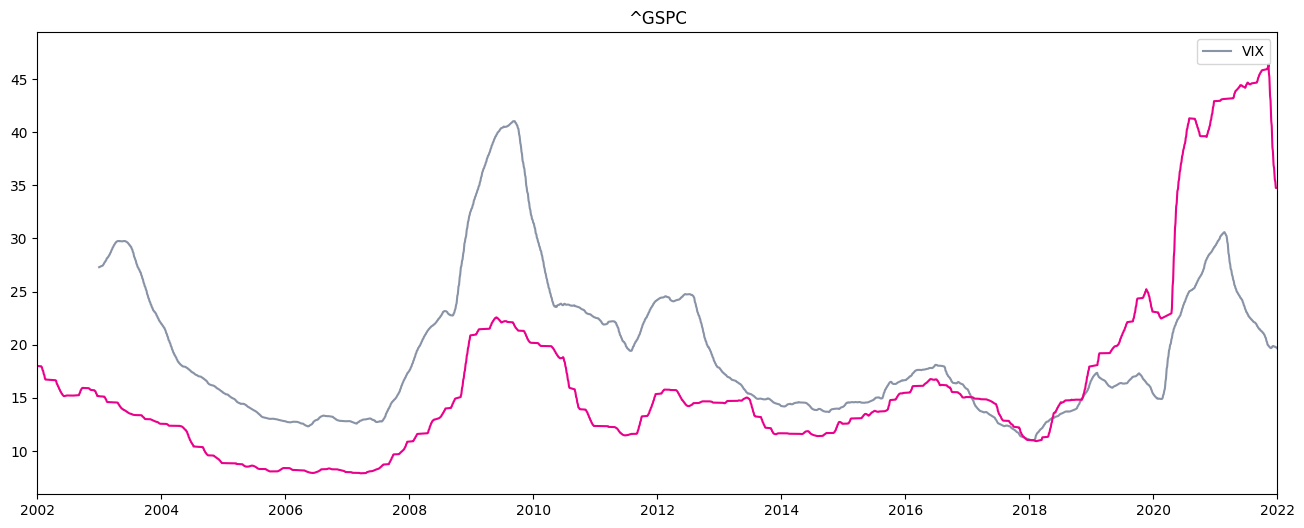

In [171]:
for col in ['^GSPC']:
    fig, ax = plt.subplots(figsize =(16,6))
    plt.title(col)
    ax.plot(vix.rolling(252).mean(),alpha = 0.5,label = 'VIX')
    #ax1 = ax.twinx()
    # i don't understand why the second sqrt works better; should not have been like that
    ax.plot(price['Adj Close'][col].diff().shift(21).rolling(21).std().dropna().rolling(252).mean(), color = base_colors[1])
    #plt.plot(np.log(-1*log_vars_parametric_norm[col]), alpha = 0.5, label = 'Parametric Normal GARCH fitted')
    #plt.plot(np.log(-1*log_vars_parametric_t_standard[col]), alpha = 0.5, label = 'Parametric Student (loc = 0, scale = 1) GARCH fitted')
    plt.xlim(datetime(2002,1,1),datetime(2022,1,1))
    #plt.ylim(-0.5,0.15)
    #ax1.legend();
    ax.legend()